<a href="https://colab.research.google.com/github/FernandaSzAdr/KNN_cromossome/blob/master/TesteRede2_Binaria_Base2_Variacao_Threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import os
import cv2
import csv
!pip install imutils
import imutils
from skimage import transform
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import itertools
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Funções

https://www.kaggle.com/questions-and-answers/39659

In [0]:
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(precisions[:-1], 'b--', label='precision')
    plt.plot(recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim(thresholds)



---



In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(architecture):
  precision = []
  recall = []
  
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Resultado3/Segmentado/Resultado_Image/' + architecture
  if os.path.isdir(local) == False:
    os.mkdir(local)
      
  thresholds = np.arange(0.1, 1.0, 0.03)
  for threshold in thresholds: 
    local = 'drive/My Drive/Resultado3/Segmentado/Resultado_Image/' + architecture + '/Threshold-' + str(threshold)
    if os.path.isdir(local) == False:
      os.mkdir(local)
      
    y_true = []
    y_predict = []
    
    for img in images_test:
      # Pega cada imagem separadamente do folder de teste
      image = cv2.imread(test_path + '/' + img)
      f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')

      copia = image.copy()

      try:
        leitor = csv.reader(f)
        leitor = list(leitor)
        leitor.pop(0)
        for linha in leitor:
          if len(linha) > 0:
            # Para cada região dessa imagem:
            if linha[0] == img:
              posicoes = []
              x = int(linha[3])
              y = int(linha[4])
              w = int(linha[5])
              h = int(linha[6])

              # Label da região
              label = linha[1]
              if label == 'NC':
                y_true.append(0)
              else:
                y_true.append(1)

              # Região
              regiao = image[y: y + h, x: x + w]
              regiao = converte(regiao)

              # Coloca a região na função e obtem o resultado
              predicao = model.predict(regiao,batch_size=bSize,verbose=0)

              # Se é um cromossomo:
              if predicao[0][1] > threshold:
                y_predict.append(1)
                cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
              # Se não for um cromossomo:
              else:
                y_predict.append(0)
                cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)

      finally:
        f.close()

      cv2.imwrite(local + '/' + img, copia)
      
    precision.append(precision_score(y_true, y_predict, average='binary'))
    recall.append(recall_score(y_true, y_predict, average='binary'))
    
    print('Threshold: {}  Precision: {}  Recall: {}'.format(threshold, precision[-1], recall[-1]))
  return precision, recall, thresholds




---



# Implementação



*   Batch size = 32
*   Image size = 120x120



## Variaveis globais



*   Batch size = 32
*   Image size = 120x120



In [0]:
train_path = 'drive/My Drive/Base_CNN/Binarizado2/Train'
test_path = 'drive/My Drive/Base_CNN/Binarizado2/Test'
validation_path = 'drive/My Drive/Base_CNN/Binarizado2/Validation'

In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [10]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 5675 images belonging to 2 classes.
Found 1509 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [12]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



## 1 tentativa

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
architecture = 'architecture_1'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [17]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.13  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.16  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.19  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.22  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.25  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.28  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.31  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.33999999999999997  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.37  Precision: 0.19641772920461445  Recall: 1.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.4  Precision: 0.0  Recall: 0.0
Threshold: 0.42999999999999994  Precision: 0.0  Recall: 0.0
Threshold: 0.45999999999999996  Precision: 0.0  Recall: 0.0
Threshold: 0.49  Precision: 0.0  Recall: 0.0
Threshold: 0.52  Precision: 0.0  Recall: 0.0
Threshold: 0.5499999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.58  Precision: 0.0  Recall: 0.0
Threshold: 0.61  Precision: 0.0  Recall: 0.0
Threshold: 0.64  Precision: 0.0  Recall: 0.0
Threshold: 0.6699999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7  Precision: 0.0  Recall: 0.0
Threshold: 0.73  Precision: 0.0  Recall: 0.0
Threshold: 0.7599999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7899999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.82  Precision: 0.0  Recall: 0.0
Threshold: 0.85  Precision: 0.0  Recall: 0.0
Threshold: 0.88  Precision: 0.0  Recall: 0.0
Threshold: 0.9099999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.94  Precision: 0.0  Recall: 0.0
Threshold: 0.97  Precision: 0.0  Recall: 0.0
Th

In [0]:
precision = np.array(precision)
recall = np.array(recall)

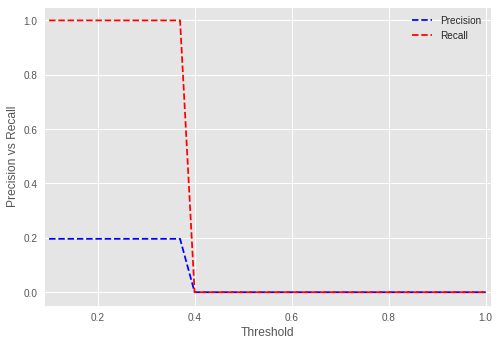

In [20]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 2 tentativa

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
architecture = 'architecture_2'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [25]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.13  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.16  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.19  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.22  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.25  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.28  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.31  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.33999999999999997  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.37  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.4  Precision: 0.17216494845360825  Recall: 0.7743431221020093


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.42999999999999994  Precision: 0.0  Recall: 0.0
Threshold: 0.45999999999999996  Precision: 0.0  Recall: 0.0
Threshold: 0.49  Precision: 0.0  Recall: 0.0
Threshold: 0.52  Precision: 0.0  Recall: 0.0
Threshold: 0.5499999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.58  Precision: 0.0  Recall: 0.0
Threshold: 0.61  Precision: 0.0  Recall: 0.0
Threshold: 0.64  Precision: 0.0  Recall: 0.0
Threshold: 0.6699999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7  Precision: 0.0  Recall: 0.0
Threshold: 0.73  Precision: 0.0  Recall: 0.0
Threshold: 0.7599999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7899999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.82  Precision: 0.0  Recall: 0.0
Threshold: 0.85  Precision: 0.0  Recall: 0.0
Threshold: 0.88  Precision: 0.0  Recall: 0.0
Threshold: 0.9099999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.94  Precision: 0.0  Recall: 0.0
Threshold: 0.97  Precision: 0.0  Recall: 0.0
Threshold: 0.9999999999999999  Precision: 0.0 

In [0]:
precision = np.array(precision)
recall = np.array(recall)

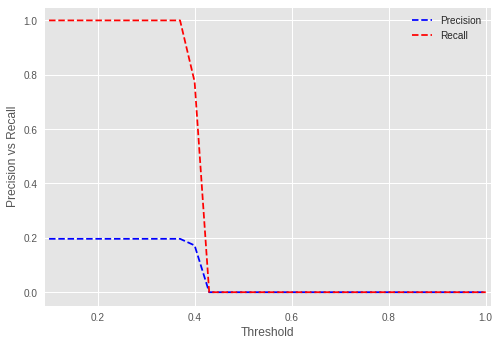

In [28]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 3 tentativa 

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
architecture = 'architecture_3'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [33]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.7371794871794872  Recall: 0.3554868624420402
Threshold: 0.13  Precision: 0.7172131147540983  Recall: 0.2704791344667697
Threshold: 0.16  Precision: 0.6789473684210526  Recall: 0.19938176197836166
Threshold: 0.19  Precision: 0.6474358974358975  Recall: 0.1561051004636785
Threshold: 0.22  Precision: 0.6044776119402985  Recall: 0.125193199381762
Threshold: 0.25  Precision: 0.514018691588785  Recall: 0.08500772797527048
Threshold: 0.28  Precision: 0.4523809523809524  Recall: 0.05873261205564142
Threshold: 0.31  Precision: 0.3888888888888889  Recall: 0.04327666151468315
Threshold: 0.33999999999999997  Precision: 0.373134328358209  Recall: 0.03863987635239567
Threshold: 0.37  Precision: 0.3387096774193548  Recall: 0.03245749613601236
Threshold: 0.4  Precision: 0.3157894736842105  Recall: 0.027820710973724884
Threshold: 0.42999999999999994  Precision: 0.29411764705882354  Recall: 0.023183925811437404
Threshold: 0.45999999999999996  Precision: 0.3191489361702128  R

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.82  Precision: 0.0  Recall: 0.0
Threshold: 0.85  Precision: 0.0  Recall: 0.0
Threshold: 0.88  Precision: 0.0  Recall: 0.0
Threshold: 0.9099999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.94  Precision: 0.0  Recall: 0.0
Threshold: 0.97  Precision: 0.0  Recall: 0.0
Threshold: 0.9999999999999999  Precision: 0.0  Recall: 0.0


In [0]:
precision = np.array(precision)
recall = np.array(recall)

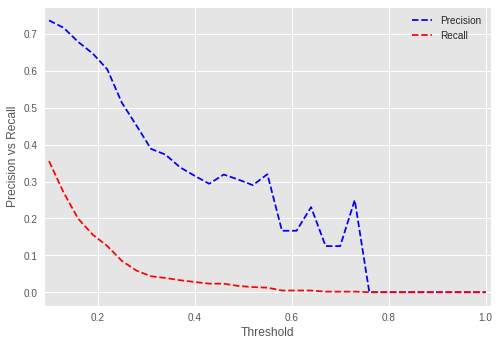

In [36]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 4 tentativa

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**


In [0]:
architecture = 'architecture_4'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [41]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.0  Recall: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.13  Precision: 0.0  Recall: 0.0
Threshold: 0.16  Precision: 0.0  Recall: 0.0
Threshold: 0.19  Precision: 0.0  Recall: 0.0
Threshold: 0.22  Precision: 0.0  Recall: 0.0
Threshold: 0.25  Precision: 0.0  Recall: 0.0
Threshold: 0.28  Precision: 0.0  Recall: 0.0
Threshold: 0.31  Precision: 0.0  Recall: 0.0
Threshold: 0.33999999999999997  Precision: 0.0  Recall: 0.0
Threshold: 0.37  Precision: 0.0  Recall: 0.0
Threshold: 0.4  Precision: 0.0  Recall: 0.0
Threshold: 0.42999999999999994  Precision: 0.0  Recall: 0.0
Threshold: 0.45999999999999996  Precision: 0.0  Recall: 0.0
Threshold: 0.49  Precision: 0.0  Recall: 0.0
Threshold: 0.52  Precision: 0.0  Recall: 0.0
Threshold: 0.5499999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.58  Precision: 0.0  Recall: 0.0
Threshold: 0.61  Precision: 0.0  Recall: 0.0
Threshold: 0.64  Precision: 0.0  Recall: 0.0
Threshold: 0.6699999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7  Precision: 0.0  Recall: 0.0
Threshold: 0.73  Precision: 0

In [0]:
precision = np.array(precision)
recall = np.array(recall)

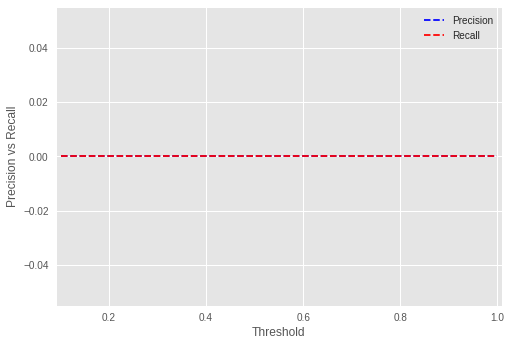

In [44]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 5 tentativa 

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_5'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [49]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.13  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.16  Precision: 0.19641772920461445  Recall: 1.0
Threshold: 0.19  Precision: 0.19300398895366677  Recall: 0.9721792890262752
Threshold: 0.22  Precision: 0.12489626556016598  Recall: 0.4652241112828439
Threshold: 0.25  Precision: 0.15193370165745856  Recall: 0.2550231839258114
Threshold: 0.28  Precision: 0.12237762237762238  Recall: 0.16228748068006182
Threshold: 0.31  Precision: 0.07901907356948229  Recall: 0.08964451313755796
Threshold: 0.33999999999999997  Precision: 0.056417489421720736  Recall: 0.061823802163833076
Threshold: 0.37  Precision: 0.034934497816593885  Recall: 0.03709428129829984
Threshold: 0.4  Precision: 0.02666666666666667  Recall: 0.027820710973724884
Threshold: 0.42999999999999994  Precision: 0.024096385542168676  Recall: 0.02472952086553323
Threshold: 0.45999999999999996  Precision: 0.0183206106870229  Recall: 0.01854714064914992
Thr

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.82  Precision: 0.0  Recall: 0.0
Threshold: 0.85  Precision: 0.0  Recall: 0.0
Threshold: 0.88  Precision: 0.0  Recall: 0.0
Threshold: 0.9099999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.94  Precision: 0.0  Recall: 0.0
Threshold: 0.97  Precision: 0.0  Recall: 0.0
Threshold: 0.9999999999999999  Precision: 0.0  Recall: 0.0


In [0]:
precision = np.array(precision)
recall = np.array(recall)

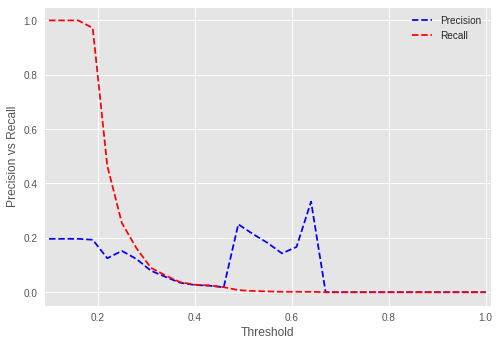

In [52]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 6 tentativa

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_6'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [57]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.3157894736842105  Recall: 0.00927357032457496
Threshold: 0.13  Precision: 0.2  Recall: 0.0015455950540958269
Threshold: 0.16  Precision: 0.0  Recall: 0.0
Threshold: 0.19  Precision: 0.0  Recall: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.22  Precision: 0.0  Recall: 0.0
Threshold: 0.25  Precision: 0.0  Recall: 0.0
Threshold: 0.28  Precision: 0.0  Recall: 0.0
Threshold: 0.31  Precision: 0.0  Recall: 0.0
Threshold: 0.33999999999999997  Precision: 0.0  Recall: 0.0
Threshold: 0.37  Precision: 0.0  Recall: 0.0
Threshold: 0.4  Precision: 0.0  Recall: 0.0
Threshold: 0.42999999999999994  Precision: 0.0  Recall: 0.0
Threshold: 0.45999999999999996  Precision: 0.0  Recall: 0.0
Threshold: 0.49  Precision: 0.0  Recall: 0.0
Threshold: 0.52  Precision: 0.0  Recall: 0.0
Threshold: 0.5499999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.58  Precision: 0.0  Recall: 0.0
Threshold: 0.61  Precision: 0.0  Recall: 0.0
Threshold: 0.64  Precision: 0.0  Recall: 0.0
Threshold: 0.6699999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7  Precision: 0.0  Recall: 0.0
Threshold: 0.73  Precision: 0.0  Recall: 0.0
Threshold: 0.7599999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7899999999999999  Precision: 0.0  Recall: 0.0
T

In [0]:
precision = np.array(precision)
recall = np.array(recall)

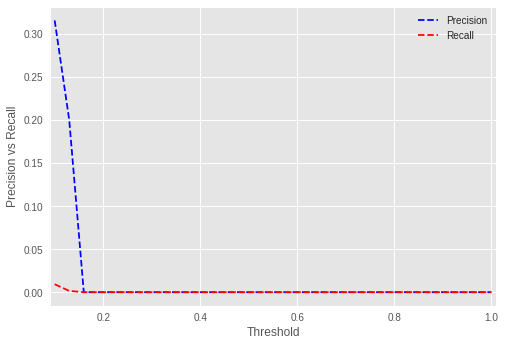

In [60]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 7 tentativa 

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_7'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [65]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.5384615384615384  Recall: 0.07573415765069552
Threshold: 0.13  Precision: 0.4426229508196721  Recall: 0.04173106646058733
Threshold: 0.16  Precision: 0.275  Recall: 0.017001545595054096
Threshold: 0.19  Precision: 0.23076923076923078  Recall: 0.00927357032457496
Threshold: 0.22  Precision: 0.21428571428571427  Recall: 0.00463678516228748
Threshold: 0.25  Precision: 0.2727272727272727  Recall: 0.00463678516228748
Threshold: 0.28  Precision: 0.25  Recall: 0.0030911901081916537
Threshold: 0.31  Precision: 0.2  Recall: 0.0015455950540958269
Threshold: 0.33999999999999997  Precision: 0.0  Recall: 0.0
Threshold: 0.37  Precision: 0.0  Recall: 0.0
Threshold: 0.4  Precision: 0.0  Recall: 0.0
Threshold: 0.42999999999999994  Precision: 0.0  Recall: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.45999999999999996  Precision: 0.0  Recall: 0.0
Threshold: 0.49  Precision: 0.0  Recall: 0.0
Threshold: 0.52  Precision: 0.0  Recall: 0.0
Threshold: 0.5499999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.58  Precision: 0.0  Recall: 0.0
Threshold: 0.61  Precision: 0.0  Recall: 0.0
Threshold: 0.64  Precision: 0.0  Recall: 0.0
Threshold: 0.6699999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7  Precision: 0.0  Recall: 0.0
Threshold: 0.73  Precision: 0.0  Recall: 0.0
Threshold: 0.7599999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7899999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.82  Precision: 0.0  Recall: 0.0
Threshold: 0.85  Precision: 0.0  Recall: 0.0
Threshold: 0.88  Precision: 0.0  Recall: 0.0
Threshold: 0.9099999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.94  Precision: 0.0  Recall: 0.0
Threshold: 0.97  Precision: 0.0  Recall: 0.0
Threshold: 0.9999999999999999  Precision: 0.0  Recall: 0.0


In [0]:
precision = np.array(precision)
recall = np.array(recall)

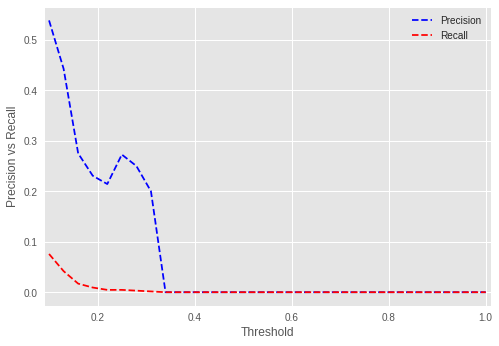

In [68]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 8 tentativa

Modelo adaptado do **Lucas Albertins**

*   Função **Adadelta** para compilação


In [0]:
architecture = 'architecture_8'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [73]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.06536856745479833  Recall: 0.07264296754250386
Threshold: 0.13  Precision: 0.045714285714285714  Recall: 0.04945904173106646
Threshold: 0.16  Precision: 0.3275862068965517  Recall: 0.02936630602782071
Threshold: 0.19  Precision: 0.2692307692307692  Recall: 0.021638330757341576
Threshold: 0.22  Precision: 0.22727272727272727  Recall: 0.015455950540958269
Threshold: 0.25  Precision: 0.18421052631578946  Recall: 0.010819165378670788
Threshold: 0.28  Precision: 0.16129032258064516  Recall: 0.0077279752704791345
Threshold: 0.31  Precision: 0.15384615384615385  Recall: 0.0061823802163833074
Threshold: 0.33999999999999997  Precision: 0.16666666666666666  Recall: 0.0061823802163833074
Threshold: 0.37  Precision: 0.19047619047619047  Recall: 0.0061823802163833074
Threshold: 0.4  Precision: 0.17647058823529413  Recall: 0.00463678516228748
Threshold: 0.42999999999999994  Precision: 0.16666666666666666  Recall: 0.0030911901081916537
Threshold: 0.45999999999999996  Prec

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.7  Precision: 0.0  Recall: 0.0
Threshold: 0.73  Precision: 0.0  Recall: 0.0
Threshold: 0.7599999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7899999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.82  Precision: 0.0  Recall: 0.0
Threshold: 0.85  Precision: 0.0  Recall: 0.0
Threshold: 0.88  Precision: 0.0  Recall: 0.0
Threshold: 0.9099999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.94  Precision: 0.0  Recall: 0.0
Threshold: 0.97  Precision: 0.0  Recall: 0.0
Threshold: 0.9999999999999999  Precision: 0.0  Recall: 0.0


In [0]:
precision = np.array(precision)
recall = np.array(recall)

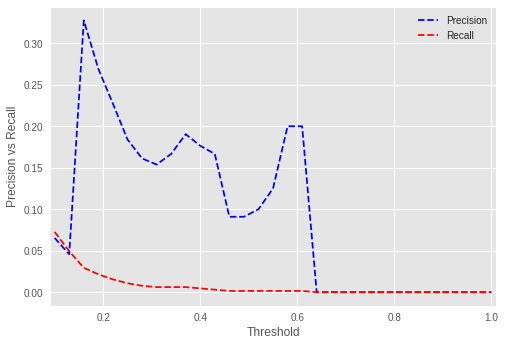

In [76]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 9 tentativa

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_9'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [81]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.3392857142857143  Recall: 0.02936630602782071
Threshold: 0.13  Precision: 0.2653061224489796  Recall: 0.02009273570324575
Threshold: 0.16  Precision: 0.23255813953488372  Recall: 0.015455950540958269
Threshold: 0.19  Precision: 0.15789473684210525  Recall: 0.00927357032457496
Threshold: 0.22  Precision: 0.15625  Recall: 0.0077279752704791345
Threshold: 0.25  Precision: 0.16  Recall: 0.0061823802163833074
Threshold: 0.28  Precision: 0.13636363636363635  Recall: 0.00463678516228748
Threshold: 0.31  Precision: 0.15  Recall: 0.00463678516228748
Threshold: 0.33999999999999997  Precision: 0.15789473684210525  Recall: 0.00463678516228748
Threshold: 0.37  Precision: 0.17647058823529413  Recall: 0.00463678516228748
Threshold: 0.4  Precision: 0.15384615384615385  Recall: 0.0030911901081916537
Threshold: 0.42999999999999994  Precision: 0.09090909090909091  Recall: 0.0015455950540958269
Threshold: 0.45999999999999996  Precision: 0.1  Recall: 0.0015455950540958269
Thres

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.7  Precision: 0.0  Recall: 0.0
Threshold: 0.73  Precision: 0.0  Recall: 0.0
Threshold: 0.7599999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7899999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.82  Precision: 0.0  Recall: 0.0
Threshold: 0.85  Precision: 0.0  Recall: 0.0
Threshold: 0.88  Precision: 0.0  Recall: 0.0
Threshold: 0.9099999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.94  Precision: 0.0  Recall: 0.0
Threshold: 0.97  Precision: 0.0  Recall: 0.0
Threshold: 0.9999999999999999  Precision: 0.0  Recall: 0.0


In [0]:
precision = np.array(precision)
recall = np.array(recall)

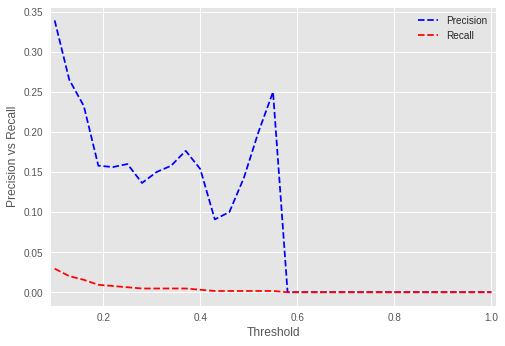

In [84]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 10 tentativa

Modelo adaptado do **Lucas Albertins**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_10'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [89]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.13333333333333333  Recall: 0.0061823802163833074
Threshold: 0.13  Precision: 0.05555555555555555  Recall: 0.0015455950540958269
Threshold: 0.16  Precision: 0.07142857142857142  Recall: 0.0015455950540958269
Threshold: 0.19  Precision: 0.09090909090909091  Recall: 0.0015455950540958269
Threshold: 0.22  Precision: 0.0  Recall: 0.0
Threshold: 0.25  Precision: 0.0  Recall: 0.0
Threshold: 0.28  Precision: 0.0  Recall: 0.0
Threshold: 0.31  Precision: 0.0  Recall: 0.0
Threshold: 0.33999999999999997  Precision: 0.0  Recall: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.37  Precision: 0.0  Recall: 0.0
Threshold: 0.4  Precision: 0.0  Recall: 0.0
Threshold: 0.42999999999999994  Precision: 0.0  Recall: 0.0
Threshold: 0.45999999999999996  Precision: 0.0  Recall: 0.0
Threshold: 0.49  Precision: 0.0  Recall: 0.0
Threshold: 0.52  Precision: 0.0  Recall: 0.0
Threshold: 0.5499999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.58  Precision: 0.0  Recall: 0.0
Threshold: 0.61  Precision: 0.0  Recall: 0.0
Threshold: 0.64  Precision: 0.0  Recall: 0.0
Threshold: 0.6699999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7  Precision: 0.0  Recall: 0.0
Threshold: 0.73  Precision: 0.0  Recall: 0.0
Threshold: 0.7599999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7899999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.82  Precision: 0.0  Recall: 0.0
Threshold: 0.85  Precision: 0.0  Recall: 0.0
Threshold: 0.88  Precision: 0.0  Recall: 0.0
Threshold: 0.9099999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.94  Precision: 0.0  Recall: 0.0
Th

In [0]:
precision = np.array(precision)
recall = np.array(recall)

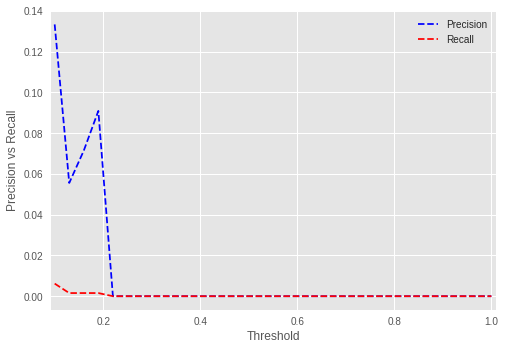

In [92]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 11 tentativa

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_11'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [97]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.19435736677115986  Recall: 0.2874806800618238
Threshold: 0.13  Precision: 0.47474747474747475  Recall: 0.07264296754250386
Threshold: 0.16  Precision: 0.36764705882352944  Recall: 0.03863987635239567
Threshold: 0.19  Precision: 0.24  Recall: 0.01854714064914992
Threshold: 0.22  Precision: 0.23404255319148937  Recall: 0.017001545595054096
Threshold: 0.25  Precision: 0.2222222222222222  Recall: 0.012364760432766615
Threshold: 0.28  Precision: 0.22580645161290322  Recall: 0.010819165378670788
Threshold: 0.31  Precision: 0.16  Recall: 0.0061823802163833074
Threshold: 0.33999999999999997  Precision: 0.16666666666666666  Recall: 0.00463678516228748
Threshold: 0.37  Precision: 0.1875  Recall: 0.00463678516228748
Threshold: 0.4  Precision: 0.2  Recall: 0.00463678516228748
Threshold: 0.42999999999999994  Precision: 0.23076923076923078  Recall: 0.00463678516228748
Threshold: 0.45999999999999996  Precision: 0.2222222222222222  Recall: 0.0030911901081916537
Threshold: 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.58  Precision: 0.0  Recall: 0.0
Threshold: 0.61  Precision: 0.0  Recall: 0.0
Threshold: 0.64  Precision: 0.0  Recall: 0.0
Threshold: 0.6699999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7  Precision: 0.0  Recall: 0.0
Threshold: 0.73  Precision: 0.0  Recall: 0.0
Threshold: 0.7599999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7899999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.82  Precision: 0.0  Recall: 0.0
Threshold: 0.85  Precision: 0.0  Recall: 0.0
Threshold: 0.88  Precision: 0.0  Recall: 0.0
Threshold: 0.9099999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.94  Precision: 0.0  Recall: 0.0
Threshold: 0.97  Precision: 0.0  Recall: 0.0
Threshold: 0.9999999999999999  Precision: 0.0  Recall: 0.0


In [0]:
precision = np.array(precision)
recall = np.array(recall)

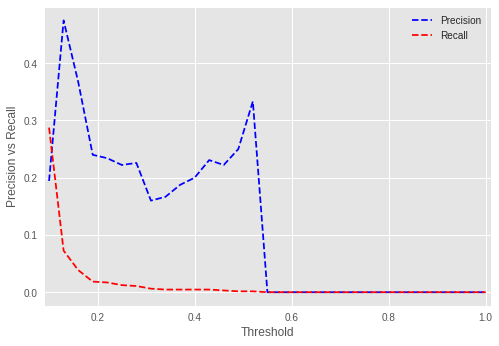

In [100]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 12 tentativa

Modelo adaptado do **Lucas Albertins**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_12'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [105]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.01524390243902439  Recall: 0.015455950540958269
Threshold: 0.13  Precision: 0.21052631578947367  Recall: 0.0061823802163833074
Threshold: 0.16  Precision: 0.125  Recall: 0.0030911901081916537
Threshold: 0.19  Precision: 0.1111111111111111  Recall: 0.0015455950540958269
Threshold: 0.22  Precision: 0.16666666666666666  Recall: 0.0015455950540958269
Threshold: 0.25  Precision: 0.2  Recall: 0.0015455950540958269
Threshold: 0.28  Precision: 0.0  Recall: 0.0
Threshold: 0.31  Precision: 0.0  Recall: 0.0
Threshold: 0.33999999999999997  Precision: 0.0  Recall: 0.0
Threshold: 0.37  Precision: 0.0  Recall: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.4  Precision: 0.0  Recall: 0.0
Threshold: 0.42999999999999994  Precision: 0.0  Recall: 0.0
Threshold: 0.45999999999999996  Precision: 0.0  Recall: 0.0
Threshold: 0.49  Precision: 0.0  Recall: 0.0
Threshold: 0.52  Precision: 0.0  Recall: 0.0
Threshold: 0.5499999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.58  Precision: 0.0  Recall: 0.0
Threshold: 0.61  Precision: 0.0  Recall: 0.0
Threshold: 0.64  Precision: 0.0  Recall: 0.0
Threshold: 0.6699999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7  Precision: 0.0  Recall: 0.0
Threshold: 0.73  Precision: 0.0  Recall: 0.0
Threshold: 0.7599999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7899999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.82  Precision: 0.0  Recall: 0.0
Threshold: 0.85  Precision: 0.0  Recall: 0.0
Threshold: 0.88  Precision: 0.0  Recall: 0.0
Threshold: 0.9099999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.94  Precision: 0.0  Recall: 0.0
Threshold: 0.97  Precision: 0.0  Recall: 0.0
Th

In [0]:
precision = np.array(precision)
recall = np.array(recall)

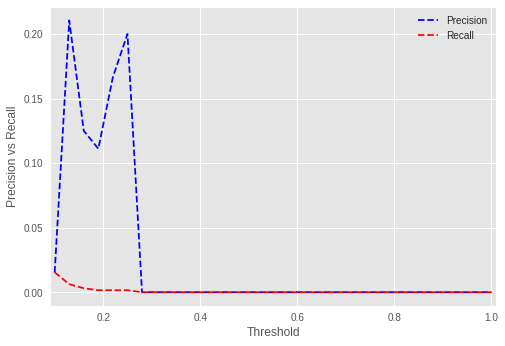

In [108]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')

## 13 tentativa 

Modelo adaptado do **Lucas Albertins**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
architecture = 'architecture_13'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

### Teste

In [17]:
precision, recall, thresholds = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Threshold: 0.1  Precision: 0.19230769230769232  Recall: 0.0077279752704791345
Threshold: 0.13  Precision: 0.16666666666666666  Recall: 0.00463678516228748
Threshold: 0.16  Precision: 0.1875  Recall: 0.00463678516228748
Threshold: 0.19  Precision: 0.15384615384615385  Recall: 0.0030911901081916537
Threshold: 0.22  Precision: 0.09090909090909091  Recall: 0.0015455950540958269
Threshold: 0.25  Precision: 0.125  Recall: 0.0015455950540958269
Threshold: 0.28  Precision: 0.16666666666666666  Recall: 0.0015455950540958269
Threshold: 0.31  Precision: 0.0  Recall: 0.0
Threshold: 0.33999999999999997  Precision: 0.0  Recall: 0.0
Threshold: 0.37  Precision: 0.0  Recall: 0.0
Threshold: 0.4  Precision: 0.0  Recall: 0.0
Threshold: 0.42999999999999994  Precision: 0.0  Recall: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 0.45999999999999996  Precision: 0.0  Recall: 0.0
Threshold: 0.49  Precision: 0.0  Recall: 0.0
Threshold: 0.52  Precision: 0.0  Recall: 0.0
Threshold: 0.5499999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.58  Precision: 0.0  Recall: 0.0
Threshold: 0.61  Precision: 0.0  Recall: 0.0
Threshold: 0.64  Precision: 0.0  Recall: 0.0
Threshold: 0.6699999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7  Precision: 0.0  Recall: 0.0
Threshold: 0.73  Precision: 0.0  Recall: 0.0
Threshold: 0.7599999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.7899999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.82  Precision: 0.0  Recall: 0.0
Threshold: 0.85  Precision: 0.0  Recall: 0.0
Threshold: 0.88  Precision: 0.0  Recall: 0.0
Threshold: 0.9099999999999999  Precision: 0.0  Recall: 0.0
Threshold: 0.94  Precision: 0.0  Recall: 0.0
Threshold: 0.97  Precision: 0.0  Recall: 0.0
Threshold: 0.9999999999999999  Precision: 0.0  Recall: 0.0


In [0]:
precision = np.array(precision)
recall = np.array(recall)

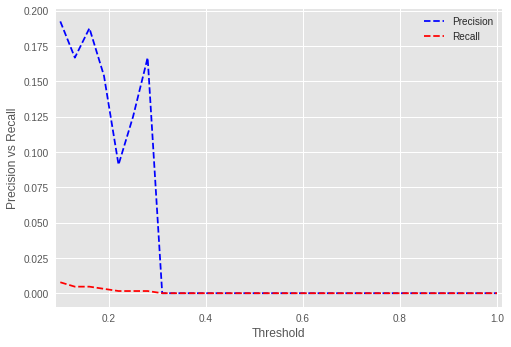

In [19]:
plt.style.use("ggplot")
plt.figure()
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'r--', label='Recall')
plt.xlabel('Threshold')
plt.xlim([0.09, 1.01])
plt.ylabel('Precision vs Recall')
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Resultado_Image/' + architecture + '/' + architecture + '_PrecisionVSRecall.png', bbox_inches='tight')